# Table of Contents

- [Libraries](#Libraries)
- [Data](#Data)
- [Multicolinearity](#Multicolinearity)
- [Modeling](#Modeling)
    - [K-Means](#K-Means)

# Libraries 

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, k_means
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [35]:
pitch_data = pd.read_csv('../datasets/mlb_pitch_stats_19_20_21.csv', index_col= ['player_id'])
pitch_data.drop(columns = ['Unnamed: 0',' first_name', 'last_name'], axis = 1, inplace = True)
print(pitch_data.shape)
pitch_data.head()

(1072, 86)


,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_brk,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,22.3,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,15.6,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,10.7,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570


# Multicolinearity

In [36]:
vif_data = pd.DataFrame()
vif_data["feature"] = pitch_data.columns

vif_data["VIF"] = [variance_inflation_factor(pitch_data.values, i)
                          for i in range(len(pitch_data.columns))]

vif_data.sort_values(by = 'VIF').head(5)

,feature,VIF
15,cg,1.364100
1,age,1.365355
81,cu_hb,1.527192
41,edge%,1.624982
29,solid_contact%,1.835575


In [37]:
X = pitch_data[['age', 'edge%', 'poor_weak%', 'ch%', '4seam%', 
                'cu%', 'cb%', 'sl_brk', 'sl%', 
                'ev_avg', 'barrel%', 
                'cb_brk', 'ch_spinrate', 
                '4seam_spinrate', '4seam_velo']]
print(X.shape)
X.head()

(1072, 15)


,age,edge%,poor_weak%,ch%,4seam%,cu%,cb%,sl_brk,sl%,ev_avg,barrel%,cb_brk,ch_spinrate,4seam_spinrate,4seam_velo
player_id,,,,,,,,,,,,,,,
425794,40,44.8,3.2,6.3,9.3,22.2,34.5,0.0,0.0,88.3,6.1,22.3,1719.0,2229.0,89.1
425844,38,42.8,5.0,21.9,40.1,0.0,16.7,8.9,15.5,88.1,6.6,15.6,1590.0,2236.0,89.0
429722,39,40.1,4.8,3.2,45.3,0.0,0.0,5.4,51.5,89.8,10.8,0.0,1690.0,2179.0,93.4
433589,37,43.3,6.6,18.1,45.1,23.3,13.5,0.0,0.0,86.4,9.1,10.7,1751.0,2135.0,87.6
445276,34,40.9,11.5,0.0,0.0,57.1,0.0,9.1,15.5,84.3,4.3,0.0,0.0,0.0,0.0


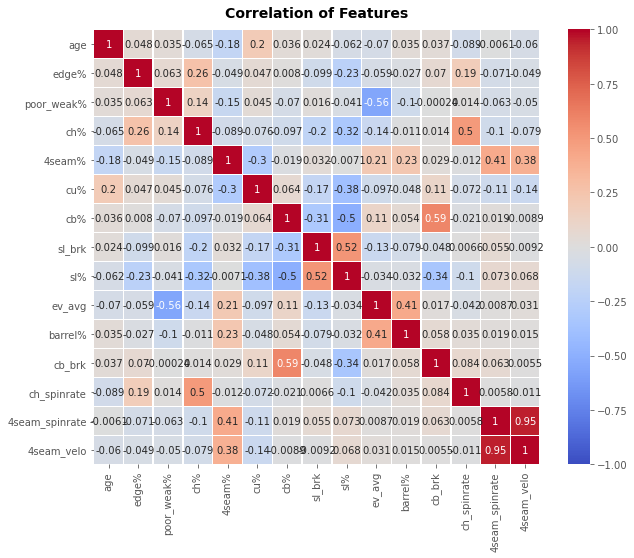

In [38]:
plt.figure(figsize = (10, 8))
sns.heatmap(X.corr(), annot = True,
            vmin = -1, 
            vmax = 1,
            linewidths = 0.5,
            cmap = 'coolwarm')
plt.title('Correlation of Features', 
          fontsize = 14, fontweight = 'bold', 
          pad = 12);

#plt.savefig('heatmap.png')

In [56]:
X2 = pitch_data[['age', 'edge%', 'poor_weak%', 'ch%', '4seam%']]

# Modeling

### Standardize Data

In [39]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

X_scaled[:,:] *= -1

### PCA

In [40]:
pca = PCA().fit(X_scaled)
principal_components = pca.transform(X_scaled)

[0.1714279  0.15337358 0.12091808 0.10823188 0.07732702 0.0693237
 0.06226266 0.05573491 0.04934515 0.04062398 0.03026491 0.02354444
 0.02254701 0.0123544  0.00272038]


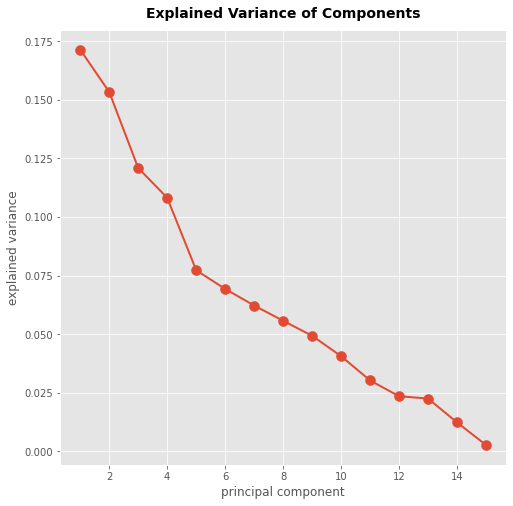

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(range(1,16), pca.explained_variance_ratio_, lw = 2)
ax.scatter(range(1, 16), pca.explained_variance_ratio_, s = 100)
ax.set_title('Explained Variance of Components', fontsize = 14, 
             fontweight = 'bold', pad = 12)
ax.set_xlabel('principal component', fontsize = 12)
ax.set_ylabel('explained variance', fontsize = 12);
print(pca.explained_variance_ratio_)

#plt.savefig('explained varience ratio.png')

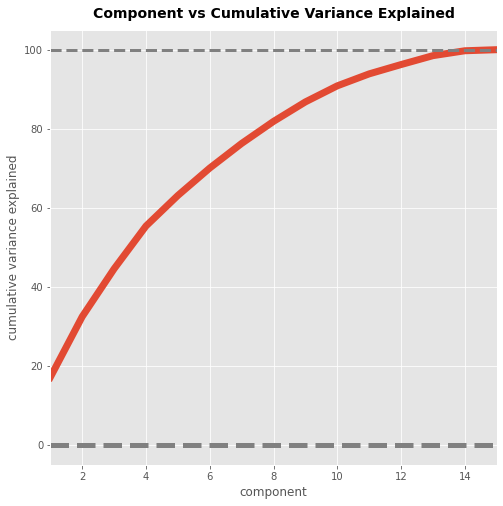

In [42]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(8,8))
component_number = range(1, 16)
plt.plot(component_number, cum_var_exp, lw = 7)
plt.axhline(y = 0, linewidth = 5, color = 'grey', ls = 'dashed')
plt.axhline(y = 100, linewidth = 3, color = 'grey', ls = 'dashed')
ax = plt.gca()
ax.set_xlim([1,15], auto = True)
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize = 12)
ax.set_xlabel('component', fontsize = 12)  
ax.set_title('Component vs Cumulative Variance Explained', 
             fontsize = 14, fontweight = 'bold', pad = 12);

#plt.savefig('component v. cumulative variance explained.png')

In [43]:
# this cell makes code for X break
#pca_component_1_eigenvec = pca.components_[0]

#for weight, X in zip(pca_component_1_eigenvec, 
#                     X.columns):
    
#    print(X, weight)

In [44]:
pitch_df = pd.DataFrame(data = principal_components, 
                        columns = X.columns)

print(pitch_df.shape)
pitch_df.head()

(1072, 15)


,age,edge%,poor_weak%,ch%,4seam%,cu%,cb%,sl_brk,sl%,ev_avg,barrel%,cb_brk,ch_spinrate,4seam_spinrate,4seam_velo
0,2.796862,-1.899731,0.345952,2.034585,0.607250,2.065537,-0.883469,-0.215811,-1.445277,-0.255999,-0.741991,-0.452934,-0.047789,0.048389,0.030665
1,0.630443,-0.205314,-0.706626,0.514618,-0.163655,2.060782,0.268378,0.001648,-1.510541,0.996698,0.456789,0.140827,-0.311615,0.347173,0.063073
2,-1.873432,1.101015,1.070963,-0.203929,1.502529,1.772302,1.479069,0.868636,-1.564469,0.109156,-1.153726,-0.532395,-0.479584,0.563387,0.240506
3,1.952894,-0.632057,-1.038966,0.867557,1.446358,0.892945,1.515156,0.266624,-0.507775,0.982365,-0.562270,-0.538122,0.247621,0.145702,0.105782
4,5.165769,6.199665,2.429492,2.491162,0.443793,-0.731012,2.072377,-0.127465,1.510307,1.785552,-0.561195,0.284510,-0.361301,0.641160,-0.016752


### K-Means

In [45]:
inertias = []
mapping = {}
K = range(1, 21)
 
for k in K:
    km = KMeans(n_clusters=k).fit(X_scaled)
    km.fit(X_scaled)
 
    inertias.append(km.inertia_)

    mapping[k] = km.inertia_

In [46]:
# inertia
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 16080.0
2 : 13913.495581215804
3 : 12247.26959334499
4 : 11327.433949641074
5 : 10559.031870132156
6 : 10012.307335773552
7 : 9610.839766159357
8 : 9260.340657594368
9 : 9010.894249548524
10 : 8721.110707647353
11 : 8519.327796428834
12 : 8373.59787439033
13 : 8227.386164586274
14 : 8045.685653042833
15 : 7932.148126056986
16 : 7810.472693258937
17 : 7690.25887250901
18 : 7567.33097179592
19 : 7468.098700116229
20 : 7390.853379831783


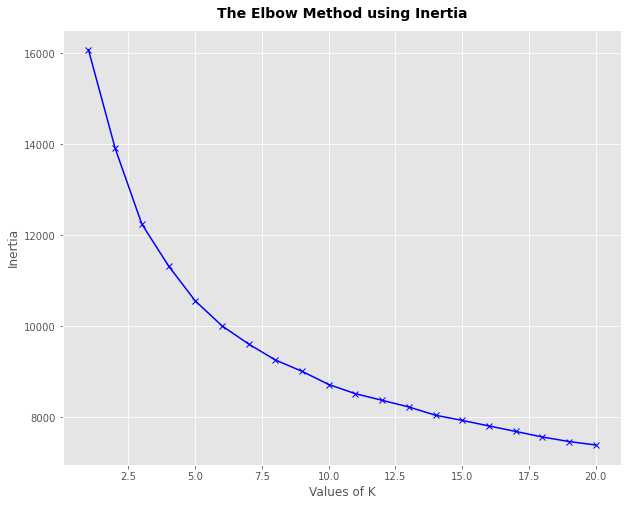

In [47]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
plt.figure(figsize = (10,8))

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('The Elbow Method using Inertia', fontsize = 14, fontweight = 'bold', pad = 12);

#plt.savefig('component v. cumulative variance explained.png')

In [54]:
km = KMeans(n_clusters = 3,
            random_state = 0)

km.fit(pitch_df)
label = km.fit_predict(pitch_df)

print(label)

[0 0 1 ... 0 1 1]


In [55]:
print('label:', km.labels_)
print('Number of iterations:', km.n_iter_)
print('Number of features:', km.n_features_in_)
print('Number of clusters:', km.n_clusters)
print('Inertia:', km.inertia_)
print('Silhouette Score:', silhouette_score(pitch_df, label))

label: [0 0 1 ... 0 1 1]
Number of iterations: 47
Number of features: 15
Number of clusters: 3
Inertia: 12254.079733577419
Silhouette Score: 0.1291930430359653


In [17]:
centroids = km.cluster_centers_
print(km.cluster_centers_, '\n')
print("Predicted clusters to points: ", label[:10], '\n')
print('Location of centroids:', '\n')
print(centroids)

[[ 1.08949695e+00  1.05010112e-01 -1.37755849e+00  2.33159161e-01
   3.11786851e-01  7.75659009e-03  6.37710144e-02  9.25082745e-03
  -9.23569506e-02 -2.72266031e-02  1.47747686e-01 -1.04927403e-02
   3.87362194e-03 -2.90380991e-02  9.07416708e-03]
 [ 4.61083974e+00  3.48211629e+00  3.17783126e+00 -1.65572146e+00
  -1.13272258e+00 -2.01839788e-01  3.99944095e-01 -2.57750786e-01
   1.09748617e-01  7.04755272e-01 -2.14766857e-01 -1.17164214e-01
   9.56286898e-03  3.06863009e-02 -1.34269166e-01]
 [-1.45417372e-02 -1.25739027e+00  3.79125511e-01  8.11138529e-03
  -3.24386489e-01  1.15100914e-01 -6.18231733e-02  5.42313173e-02
   1.04061702e-01  1.82038609e-02 -1.34166749e-02  2.63178790e-02
   1.12360183e-03  4.60072024e-03  8.58390520e-04]
 [-1.35704400e+00  9.78901451e-01  1.90160492e-01  1.91536867e-02
   2.88748037e-01 -1.16818168e-01 -2.34346163e-02 -3.93364479e-02
  -6.73502158e-02 -8.72889459e-02 -6.79176100e-02 -8.90556997e-03
  -5.37609964e-03  1.24408299e-02  8.63610877e-03]] 

P

In [18]:
#centroids_x = centroids[:5, 0:3:2]
print('x', centroids[:5, 0:3:2], '\n')
#centroids_y = centroids[:5, 1:4:2]
#print('y', centroids_y, '\n')
centroids_x = centroids[:, 0]
print('x:', centroids_x, '\n')
centroids_y = centroids[:, 1]
print('y:', centroids_y)

x [[ 1.08949695 -1.37755849]
 [ 4.61083974  3.17783126]
 [-0.01454174  0.37912551]
 [-1.357044    0.19016049]] 

x: [ 1.08949695  4.61083974 -0.01454174 -1.357044  ] 

y: [ 0.10501011  3.48211629 -1.25739027  0.97890145]


In [19]:
X['label'] = label
pitch_df['label'] = label
pitch_df.head()

,age,edge%,poor_weak%,ch%,4seam%,cu%,cb%,sl_brk,sl%,ev_avg,barrel%,cb_brk,ch_spinrate,4seam_spinrate,4seam_velo,label
0,2.796862,-1.899731,0.345952,2.034585,0.607250,2.065537,-0.883469,-0.215811,-1.445277,-0.255999,-0.741991,-0.452934,-0.047789,0.048389,0.030665,2
1,0.630443,-0.205314,-0.706626,0.514618,-0.163655,2.060782,0.268378,0.001648,-1.510541,0.996698,0.456789,0.140827,-0.311615,0.347173,0.063073,0
2,-1.873432,1.101015,1.070963,-0.203929,1.502529,1.772302,1.479069,0.868636,-1.564469,0.109156,-1.153726,-0.532395,-0.479584,0.563387,0.240506,3
3,1.952894,-0.632057,-1.038966,0.867557,1.446358,0.892945,1.515156,0.266624,-0.507775,0.982365,-0.562270,-0.538122,0.247621,0.145702,0.105782,0
4,5.165769,6.199665,2.429492,2.491162,0.443793,-0.731012,2.072377,-0.127465,1.510307,1.785552,-0.561195,0.284510,-0.361301,0.641160,-0.016752,1


In [20]:
pitch_df.groupby(by = 'label').mean().T

label,0,1,2,3
age,1.089497,4.610840,-0.014542,-1.357044
edge%,0.105010,3.482116,-1.257390,0.978901
poor_weak%,-1.377558,3.177831,0.379126,0.190160
ch%,0.233159,-1.655721,0.008111,0.019154
4seam%,0.311787,-1.132723,-0.324386,0.288748
cu%,0.007757,-0.201840,0.115101,-0.116818
cb%,0.063771,0.399944,-0.061823,-0.023435
sl_brk,0.009251,-0.257751,0.054231,-0.039336
sl%,-0.092357,0.109749,0.104062,-0.067350
ev_avg,-0.027227,0.704755,0.018204,-0.087289


Cluster 0: likely all relievers, 0 ch %

Cluster 1: likely majority starters, high ch %

Cluster 2: Oldest group, likely majority starters, highest ch %

Cluster 3: youngest group, likely majority relievers, heavy fastball %

In [21]:
X.groupby(by = 'label').mean().T

label,0,1,2,3
age,29.858779,29.325581,28.592771,28.843750
edge%,43.659160,42.683721,42.263133,41.728977
poor_weak%,5.822137,4.674419,3.342651,4.068182
ch%,19.964885,13.372093,9.114217,5.956818
4seam%,27.059542,0.000000,42.439759,36.887784
cu%,11.543511,15.265116,7.618313,2.583239
cb%,10.142366,10.134884,18.405783,1.828977
sl_brk,4.274046,6.053488,5.090602,7.992045
sl%,9.029389,14.762791,12.084819,32.902557
ev_avg,87.141603,88.395349,89.447229,88.584375


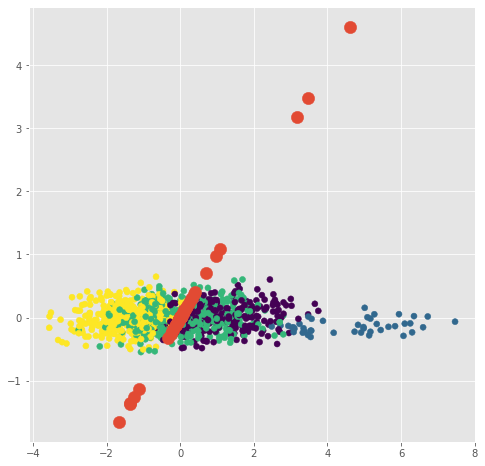

In [22]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['4seam_velo'], 
            c = pitch_df['label']);
plt.scatter(centroids, 
            centroids, 
            marker = 'o', s = 150);

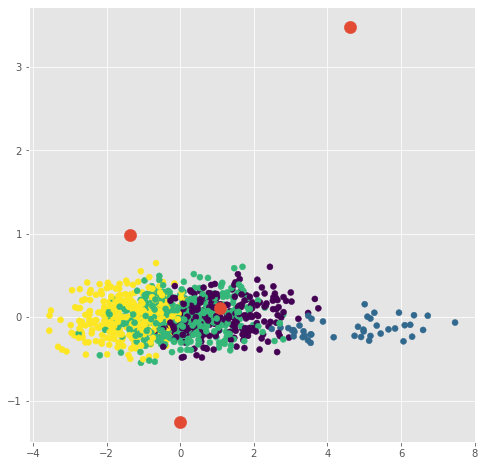

In [23]:
plt.figure(figsize = (8, 8))

plt.scatter(pitch_df['age'], pitch_df['4seam_velo'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

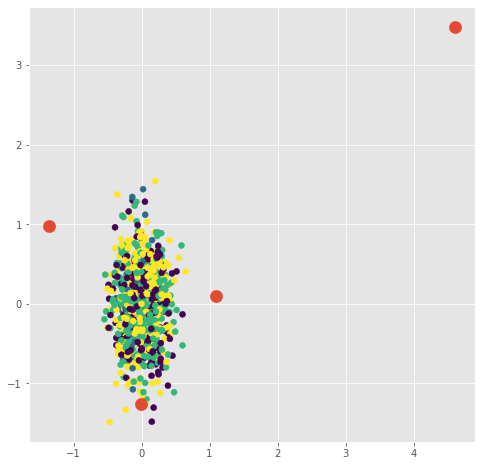

In [24]:
plt.figure(figsize=(8, 8))

plt.scatter(pitch_df['4seam_velo'], pitch_df['4seam_spinrate'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

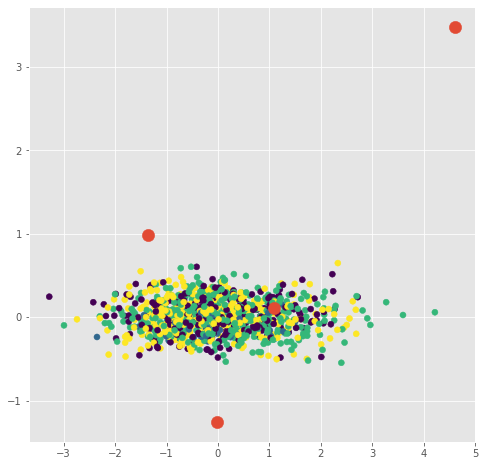

In [25]:
plt.figure(figsize=(8, 8))

plt.scatter(pitch_df['cu%'], pitch_df['4seam_velo'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

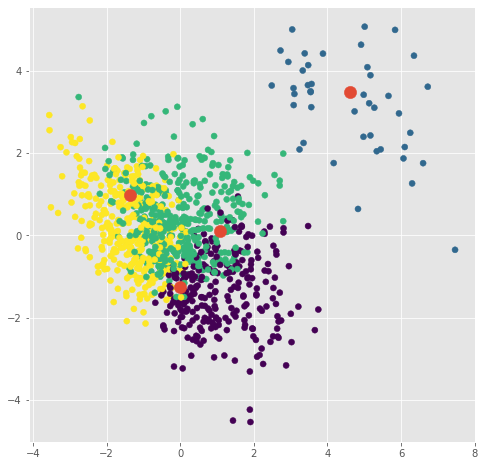

In [26]:
plt.figure(figsize=(8, 8))

plt.scatter(pitch_df['age'], pitch_df['poor_weak%'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

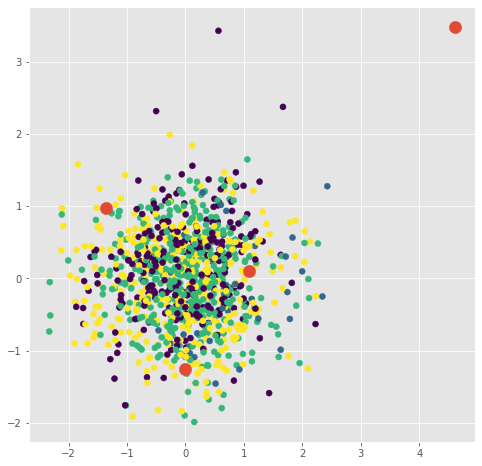

In [27]:
plt.figure(figsize=(8, 8))

plt.scatter(pitch_df['ev_avg'], pitch_df['barrel%'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

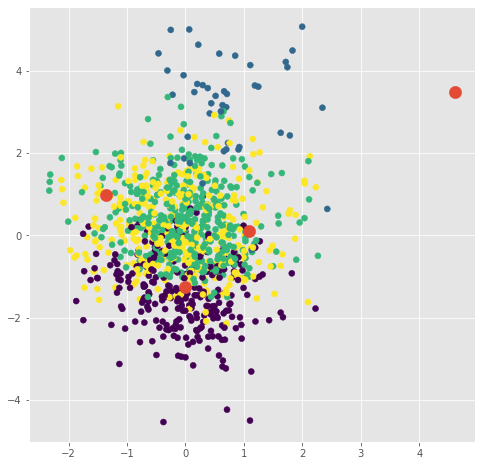

In [28]:
plt.figure(figsize=(8, 8))

plt.scatter(pitch_df['ev_avg'], pitch_df['poor_weak%'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

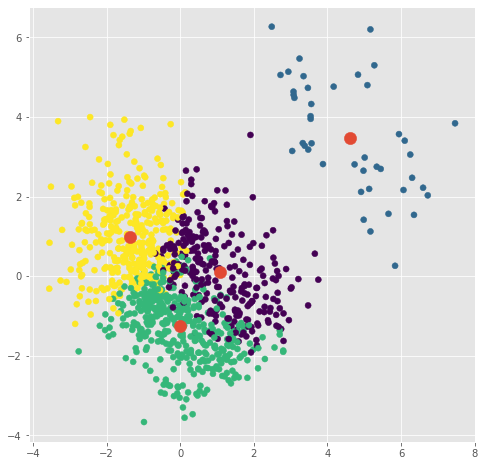

In [29]:
plt.figure(figsize=(8, 8))

plt.scatter(pitch_df['age'], pitch_df['edge%'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

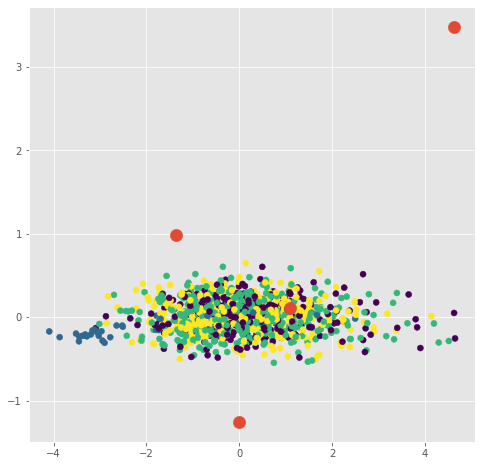

In [30]:
plt.figure(figsize=(8, 8))

plt.scatter(pitch_df['ch%'], pitch_df['4seam_velo'], 
            c = pitch_df['label']);
plt.scatter(centroids_x, 
            centroids_y, 
            marker = 'o', s = 150);

In [31]:
#pitch_df = pitch_df.values
#plt.figure(figsize = (8,8))
#plt.scatter(pitch_df[label == 0, 0], pitch_df[label == 0, 1], c = 'red', label = 'Cluster 1')
#plt.scatter(pitch_df[label == 1, 0], pitch_df[label == 1, 1], c = 'blue', label = 'Cluster 2')
#plt.scatter(pitch_df[label == 2, 0], pitch_df[label == 2, 1], c = 'green', label = 'Cluster 3')
#plt.scatter(pitch_df[label == 3, 0], pitch_df[label == 3, 1], c = 'cyan', label = 'Cluster 4')
#plt.scatter(centroids_x, centroids_y, s = 150, c = 'yellow', label = 'Centroids');